In [ ]:
!kaggle datasets list

In [ ]:
!kaggle datasets list -s flowers

In [ ]:
# Download the dataset
!kaggle datasets download -d alxmamaev/flowers-recognition

In [ ]:
# Unzip the dataset
!tar -xf flowers-recognition.zip

In [ ]:
# Import modules
import os
from PIL import Image
import random
import matplotlib.pyplot as plt 

In [ ]:
# Explore the data
fig = plt.figure(figsize=(15,15)) 
tot_images = 20
num_images_for_each = 4
for num_folder, folder in enumerate(os.listdir("flowers")):
    print("Number of images of ", folder,":",len(os.listdir("flowers/" + folder)))
    files = os.listdir("flowers/" + folder)
    random.shuffle(files)
    for num, fn in enumerate(files[:num_images_for_each]):
        path = os.path.join("flowers/" + folder,fn)
        img = Image.open(path)
        plt.subplot(tot_images//4,4,num_folder*4+num+1)
        plt.title(folder)
        plt.axis('off')
        plt.imshow(img)
plt.show()

Let's try our first attempt with the Plain-CNN that we defined last time! 

In [6]:
from model import PlainCNN
import torch

# Test the network 
model = PlainCNN([1,2,2,2,2], 5)
model.test_forward(torch.randn(1,3,224,224))

torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 56, 56])
torch.Size([1, 64, 56, 56])
torch.Size([1, 128, 28, 28])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 7, 7])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 5])


In [5]:
from train_utils import train
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transf
from dataset import FlowerDataset, get_train_val_loaders, split_dataset

# Define the transformations 
transforms_train = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
transforms_test_val = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

train_images, val_images, test_images = split_dataset("flowers", train_proportion=0.8, val_proportion=0.1)

trainset = FlowerDataset(train_images, transforms_train)
valset = FlowerDataset(val_images, transforms_test_val)

trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = PlainCNN([1,4,4,4,4], n_classes=5)
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Trainable model parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 1

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9)

# Get the loss function 
loss_fn = CrossEntropyLoss(reduction="mean")

# Call the train function
train(model=model, 
      trainloader=trainloader, 
      valloader=valloader, 
      epochs=epochs, 
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      save_directory=model._getname_())

Total number of images:  4317


NameError: name 'torch' is not defined

### TEST ON SOME IMAGES

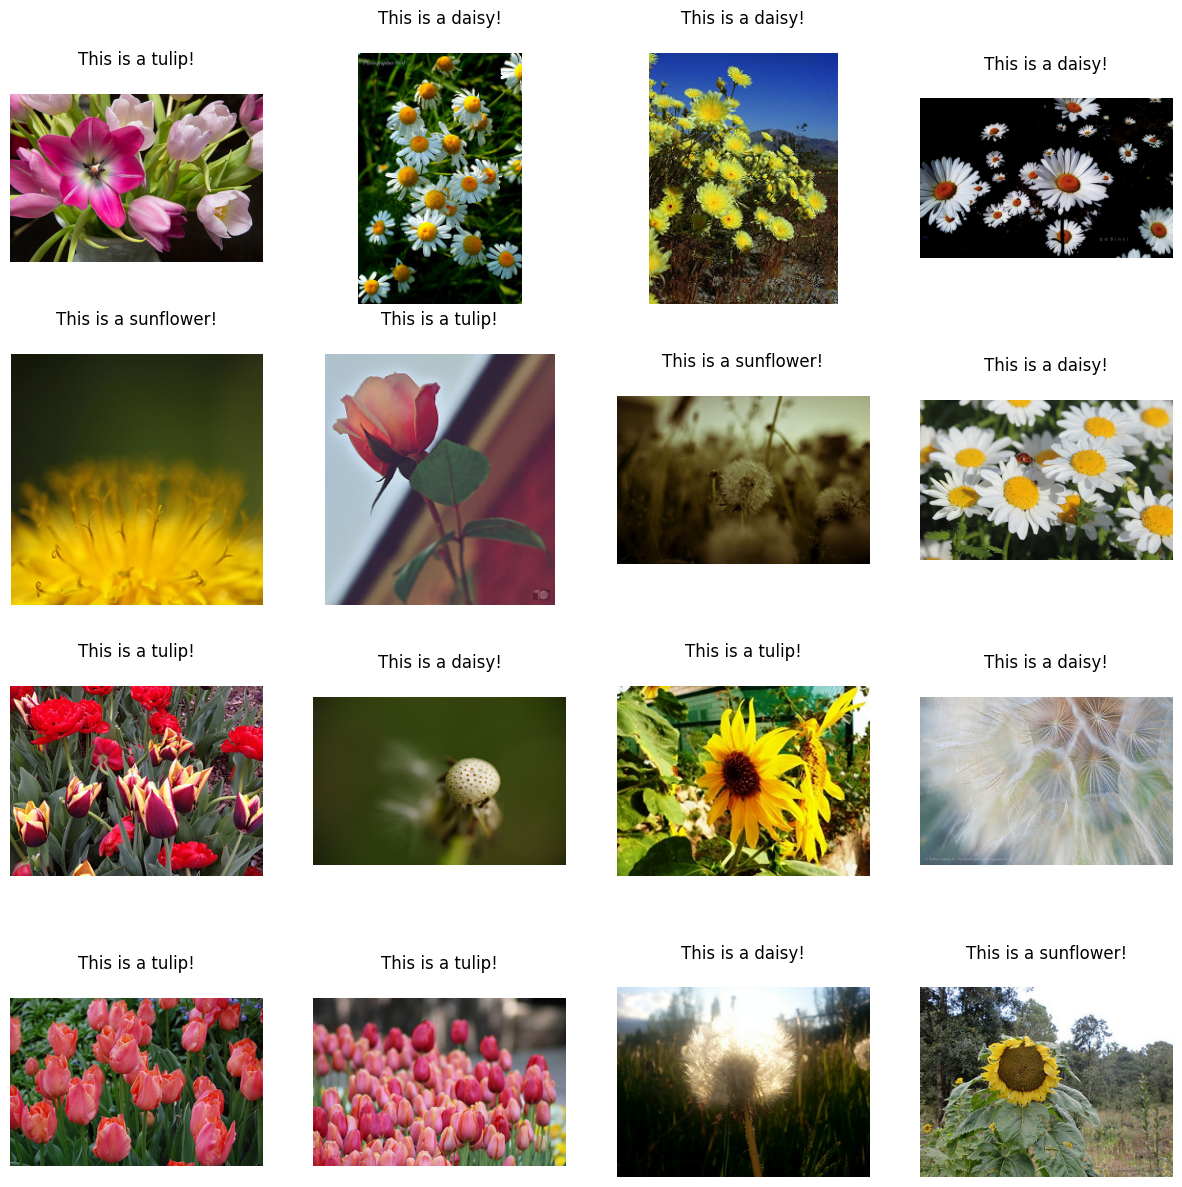

In [7]:
import matplotlib.pyplot as plt
from dataset import FlowerDataset
from dataset import get_test_loader
import os

# Load the weights of the network 
model = PlainCNN([1,4,4,4,4], n_classes=5)
model.load_state_dict(torch.load(os.path.join(model._getname_(),"model_1_epochs.pt")))

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [12]:
from tqdm import tqdm 

# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
labels_list = []
predicted_labels_list = []
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
        predicted_labels = predictions.argmax(1).tolist()
        
        labels_list.extend(labels.tolist())
        predicted_labels_list.extend(predicted_labels)
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

100%|██████████| 109/109 [00:07<00:00, 15.32it/s]


Test loss: 1.4737130868325539
Test accuracy: 0.3761467889908257


              precision    recall  f1-score   support

           0       0.32      0.80      0.46       153
           1       0.00      0.00      0.00       211
           2       0.28      0.03      0.06       157
           3       0.37      0.36      0.36       147
           4       0.45      0.75      0.56       197

    accuracy                           0.38       865
   macro avg       0.28      0.39      0.29       865
weighted avg       0.27      0.38      0.28       865



c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

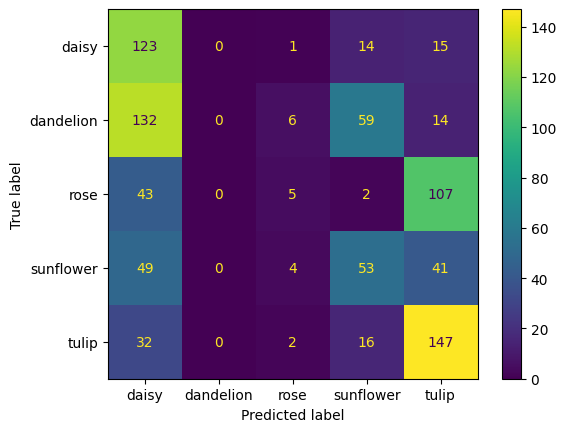

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(labels_list, predicted_labels_list)
report = classification_report(labels_list, predicted_labels_list)
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["daisy", "dandelion", "rose", "sunflower", "tulip"])
disp.plot()
plt.show()

# NOW LET'S TRY WITH SKIP CNN!

In [ ]:
# Let's see if the number of parameters is the same as the resnet18 from pytorch!

from torchvision.models import resnet18
from model import SkipCNN
import torch.nn as nn

resnet = resnet18()
resnet.fc = nn.Linear(512,5)

print("Parameters of the ResNet18 model:", sum([param.numel() for param in resnet.parameters()]))

model = SkipCNN([1,2,2,2,2], n_classes=5)

print("Parameters of the SkipCNN model:", sum([param.numel() for param in model.parameters()]))

del model
del resnet

In [ ]:
from train_utils import train
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transf
from dataset import FlowerDataset, get_train_val_loaders, split_dataset

# Define the transformations 
transforms_train = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
transforms_test_val = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

train_images, val_images, test_images = split_dataset("flowers", train_proportion=0.8, val_proportion=0.1)

trainset = FlowerDataset(train_images, transforms_train)
valset = FlowerDataset(val_images, transforms_test_val)

trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = SkipCNN([1,2,2,2,2], n_classes=5)
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Trainable model parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 1

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9)

# Get the loss function 
loss_fn = CrossEntropyLoss(reduction="mean")

# Call the train function
train(model=model, 
      trainloader=trainloader, 
      valloader=valloader, 
      epochs=epochs, 
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      save_directory=model._getname_())

In [ ]:
import matplotlib.pyplot as plt
from dataset import FlowerDataset
from dataset import get_test_loader
import os

# Load the weights of the network 
model = SkipCNN([1,2,2,2,2], n_classes=5)
model.load_state_dict(torch.load(os.path.join(model._getname_(),"model_1_epochs.pt")))

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

# Do it with transfer learning 

In [ ]:
from train_utils import train
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transf
from dataset import FlowerDataset, get_train_val_loaders, split_dataset
from torchvision.models import resnet18, ResNet18_Weights

# Define the transformations 
transforms_train = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
transforms_test_val = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

train_images, val_images, test_images = split_dataset("flowers", train_proportion=0.8, val_proportion=0.1)

trainset = FlowerDataset(train_images, transforms_train)
valset = FlowerDataset(val_images, transforms_test_val)

trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = resnet18(weights=ResNet18_Weights.DEFAULT)
# Modify the last classification layer 
model.fc = nn.Linear(512,5)
# Freeze all except the last layer
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
    
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Trainable model parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 1

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9)

# Get the loss function 
loss_fn = CrossEntropyLoss(reduction="mean")

# Call the train function
train(model=model, 
      trainloader=trainloader, 
      valloader=valloader, 
      epochs=epochs, 
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      save_directory="Resnet18_Linear_Probing")

In [ ]:
import matplotlib.pyplot as plt
from dataset import FlowerDataset
from dataset import get_test_loader
import os

# Load the network with random initialized weights
model = resnet18()
# Modify the last classification layer 
model.fc = nn.Linear(512,5)
model.load_state_dict(torch.load(os.path.join("Resnet18_Linear_Probing","model_1_epochs.pt")))

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

In [ ]:
from train_utils import train
from torch.optim import SGD
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transf
from dataset import FlowerDataset, get_train_val_loaders, split_dataset
from torchvision.models import resnet50, ResNet50_Weights

# Define the transformations 
transforms_train = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
transforms_test_val = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

train_images, val_images, test_images = split_dataset("flowers", train_proportion=0.8, val_proportion=0.1)

trainset = FlowerDataset(train_images, transforms_train)
valset = FlowerDataset(val_images, transforms_test_val)

trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = resnet50(weights=ResNet50_Weights.DEFAULT)
# Modify the last classification layer 
model.fc = nn.Linear(2048,5)
# Freeze all except the last layer
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
    
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Trainable model parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 1

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9)

# Get the loss function 
loss_fn = CrossEntropyLoss(reduction="mean")

# Call the train function
train(model=model, 
      trainloader=trainloader, 
      valloader=valloader, 
      epochs=epochs, 
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      save_directory="Resnet50_Linear_Probing")

In [ ]:
import matplotlib.pyplot as plt
from dataset import FlowerDataset
from dataset import get_test_loader
import os

# Load the weights of the network 
model = resnet50()
# Modify the last classification layer 
model.fc = nn.Linear(2048,5)
model.load_state_dict(torch.load(os.path.join("Resnet50_Linear_Probing","model_1_epochs.pt")))

fig = plt.figure(figsize=(15,15))
num_images = 16
testset = FlowerDataset(test_images, None)
testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
from tqdm import tqdm

# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

In [ ]:
from train_utils import train
from torch.optim import SGD
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
import torchvision.transforms as transf
from dataset import FlowerDataset, get_train_val_loaders, split_dataset
from torchvision.models import resnet101, ResNet101_Weights

# Define the transformations 
transforms_train = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])
transforms_test_val = transf.Compose([
                            transf.Resize((224,224), antialias=True), 
                            transf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                            ])

train_images, val_images, test_images = split_dataset("flowers", train_proportion=0.8, val_proportion=0.1)

trainset = FlowerDataset(train_images, transforms_train)
valset = FlowerDataset(val_images, transforms_test_val)

trainloader, valloader = get_train_val_loaders(trainset, valset, batch_size=8)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model 
model = resnet101(weights=ResNet101_Weights.DEFAULT)
# Modify the last classification layer 
model.fc = nn.Linear(2048,5)
# Freeze all except the last layer
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False
    
model.to(device)

print("Tot model parameters:", sum([param.numel() for param in model.parameters()]))
print("Trainable model parameters:", sum([param.numel() for param in model.parameters() if param.requires_grad]))

# Hyperparameters 
learning_rate = 5e-3
epochs = 1

# Get the optimizer
optimizer = SGD(model.parameters(),lr=learning_rate, weight_decay=1e-4, momentum=0.9)

# Get the loss function 
loss_fn = CrossEntropyLoss(reduction="mean")

# Call the train function
train(model=model, 
      trainloader=trainloader, 
      valloader=valloader, 
      epochs=epochs, 
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      save_directory="Resnet101_Linear_Probing")

In [ ]:
import matplotlib.pyplot as plt

# Load the weights of the network 
model = resnet101()
# Modify the last classification layer 
model.fc = nn.Linear(2048,5)
model.load_state_dict(torch.load(os.path.join("Resnet101_Linear_Probing","model_1_epochs.pt")))

fig = plt.figure(figsize=(15,15))
num_images = 16
train_images, val_images, test_images = split_dataset("flowers", train_proportion=0.8, val_proportion=0.1)
testset = FlowerDataset(test_images, None)

testloader = get_test_loader(testset, batch_size=1)
testloader = iter(testloader)

model.eval()
with torch.no_grad():
  for i in range(num_images):
    image, label = next(testloader)
    # Apply transformation on image
    image_transf = transforms_test_val(image)
    out = model(image_transf)
    prediction = out.argmax(1)
    plt.subplot(num_images//4,4,i+1)
    plt.axis('off')
    plt.imshow(image.squeeze().moveaxis(0,-1))
    if(prediction.item()==0):
      plt.title("This is a daisy!\n")
    elif (prediction.item()==1):
      plt.title("This is a dandelion!\n")
    elif (prediction.item()==2):
      plt.title("This is a rose!\n")
    elif (prediction.item()==3):
      plt.title("This is a sunflower!\n")
    elif(prediction.item()==4):
      plt.title("This is a tulip!\n")

plt.show()

In [ ]:
from tqdm import tqdm

# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))

In [ ]:
from tqdm import tqdm

# Let's calculate the accuracy on the test set 
testset = FlowerDataset(test_images, transforms_test_val)
testloader = get_test_loader(testset, batch_size=8)
loss_fn = CrossEntropyLoss(reduction="mean")
# Put the model in evaluation mode
model.eval()
# Send the model to the device
model.to(device)
with torch.no_grad():
    loss_test = 0 
    accuracy_test = 0
    for i, data in enumerate(tqdm(testloader)):
        imgs, labels = data 
        # Send data to device
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Predict
        predictions = model(imgs)
        loss = loss_fn(predictions,labels)
        loss_test += loss.item()
        accuracy_test += (sum(predictions.argmax(1)==labels)/imgs.shape[0]).item()
        
print("\nTest loss:",loss_test/len(testloader))
print("Test accuracy:",accuracy_test/len(testloader))